In [ ]:
import math, random
import copy
import gym
import numpy as np
from collections import deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)
USE_CUDA

True

In [ ]:
class Model(nn.Module):
  
  def __init__(self, env):
      super(Model, self).__init__()
      
      
      self.feature = nn.Sequential(
          nn.Linear(env.observation_space.shape[0], 128),
          nn.ReLU()
      )
      
      self.advantage = nn.Sequential(
          nn.Linear(128, 128),
          nn.ReLU(),
          nn.Linear(128, env.action_space.n)
      )
      
      self.value = nn.Sequential(
          nn.Linear(128, 128),
          nn.ReLU(),
          nn.Linear(128, 1)
      )
      
  def policy(self, x):
      x = self.feature(x)
      advantage = self.advantage(x)
      value     = self.value(x)
      return value + advantage  - advantage.mean()
  
  def selection_action(self, state, epsilon):

      # """
      #   This epsilon is for eps-greedy plociy
      # """
    q=0
    if random.random() > epsilon:

      state= Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
      q_value= self.policy(state)
      action= q_value.max(1)[1].data[0].item() 
      q= q_value.max(1)[0].data[0].item()
    else:

      action= random.randrange(env.action_space.n)
    return action, q

In [ ]:
class Dueling_DQNAgent():
  """
  Class that defines the functions required for training the DQN agent
  """
  def __init__(self, env, batch_size= 32, gamma= 0.99, eps_max= 0.2, lr= 1e-3, N= 100000, eps_end= 0.05, eps_decay= 500):
    self.gamma= gamma
    # for epsilon-greedy exploration strategy
    self.eps_max= eps_max
    self.eps_decay= eps_decay
    self.eps_end= eps_end
    self.lr= lr

    self.n_action= env.action_space.n
    self.input_dims= env.observation_space.shape[0]
    self.memory= N
    self.batch_size= batch_size

    # instances of the network for current policy and its target
    self.q_net= Model(env)
    self.tg_net= copy.deepcopy(self.q_net)

    self.criteria = torch.nn.MSELoss()
    # self.optimizer = torch.optim.SGD(q_net.parameters(), lr=self.lr, momentum=0.9)
    self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=self.lr)

    # instance of the replay buffer
    self.Buffer = deque(maxlen=self.memory)

  def insert(self, state, action, reward, next_state, done):

    """
    sars= (s, a, r, s') this is a transition that will be store in the Buffer.
    done is a bool variable, that tells us whether a state is termial or not.
    """
    state= np.expand_dims(state, 0)
    next_state= np.expand_dims(next_state, 0)
        
    self.Buffer.append((state, action, reward, next_state, done))

  def buffer_size(self):
    """
      This function return the size of the Replay Buffer.
    """

    return len(self.Buffer)

  def sample_Buffer(self, m):
    """
      Function to pick 'm' samples from the memory that are selected uniformly at random, such that m = batchsize

      Parameters
      ---
      batchsize: int
          Number of elements to randomly sample from the memory in each batch
      device: str
          Name of the device (cuda or cpu) on which the computations would be performed

      Returns
      ---
      Tensors representing a batch of transitions sampled from the memory
    """
    state, action, reward, next_state, done = zip(*random.sample(self.Buffer, m))
    return np.concatenate(state), action, reward, np.concatenate(next_state), done

In [ ]:
env = gym.make('CartPole-v1')

In [ ]:
epsilon_start = 0.2
epsilon_final = 0.05
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay) #Frame means episode

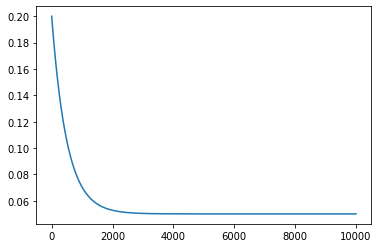

In [ ]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

In [ ]:
## Instanciate the agent
agent = Dueling_DQNAgent(env)
q_net = agent.q_net
tg_net= agent.tg_net

if USE_CUDA:
    q_net = q_net.cuda()
    tg_net= tg_net.cuda()
    
grad_clip= 1.0
TARGET_UPDATE = 100
# tg_net= agent.tg_net.cuda()
tg_net.load_state_dict(q_net.state_dict())

<All keys matched successfully>

In [ ]:
def eps_greedy(eps_max, eps_end, episode_idx, eps_decay, num_eps):
  return eps_end + (eps_max - eps_end) * math.exp(-1. * episode_idx / eps_decay)

In [ ]:
def train(env):
  # if agent.buffer_size() < agent.batch_size:
  #   return 
  s_batch, a_batch, r_batch, s_n_batch, done_bacth = agent.sample_Buffer(agent.batch_size)

  s_batch= Variable(torch.FloatTensor(np.float32(s_batch)))
  a_batch= Variable(torch.LongTensor(a_batch))

  s_n_batch= Variable(torch.FloatTensor(np.float32(s_n_batch)), volatile=True)
  r_batch= Variable(torch.FloatTensor(r_batch))

  done_bacth= Variable(torch.FloatTensor(done_bacth))

  ## We 
  q_values= q_net.policy(s_batch)

  # We Compute the expected Q values by using target Network
  next_q_values= tg_net.policy(s_n_batch)

  q_value= q_values.gather(1, a_batch.unsqueeze(1)).squeeze(1)
  next_q_value= next_q_values.max(1)[0]

  expected_q_value= r_batch + agent.gamma * next_q_value * (1 - done_bacth) # Target from Bellmann Equation

  ## Loss Computation

  # loss= agent.criteria(q_value, expected_q_value)
  loss= F.smooth_l1_loss(q_value, expected_q_value).mean()

  ## ---- Optimization step ------- ##
  agent.optimizer.zero_grad()
  loss.backward(retain_graph=True)
  agent.optimizer.step()
  ## ---- Optimization step ------- ##
  
  return loss

In [ ]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. average rewards per episode: %s' % (frame_idx, rewards)) # 100 Last avg
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [ ]:
%%time
scores, avg_scores, epis_history, losses_all, q_values_all,scores_all, eps_history = [], [], [], [], [], [], []
num_episodes= 1500
# best_rewards= 0
counter= 0
scores= []
reward_threshold= 475
min_episodes_criterion= 500
for i in range(1, num_episodes+1):
# with tqdm.trange(1, num_episodes) as t:
  score= 0
  losses= 0
  ep_len= 0
  done= False
  obs= env.reset()

  res= [eps_greedy(agent.eps_max, agent.eps_end, episode_idx, agent.eps_decay, num_episodes) for episode_idx in range(num_episodes+1)]
  epsilon= res[i]
  # epsilon= annealing(agent)

  
  episode_q_values= []
  episode_scores= []
  episode_loss= []

  # for j in range(min_episodes_criterion):
  while not done:

  # while not done:
    ep_len += 1 

    action, q = q_net.selection_action(obs, epsilon)
    episode_q_values.append(q)

    next_state, reward, done, info = env.step(action)
    # reward = reward if not done else -10
    score+=reward

    ## Store experience to the memeory
    agent.insert(obs, action, reward, next_state, done)

    obs= next_state

    if agent.buffer_size() > agent.batch_size:
      loss= train(agent)
      episode_loss.append(loss.item())

    if i % 10 == 0:
      pass # print(f'Episode {i}: average reward: {avg_reward}')
    # Early stopping
    

  losses_all.append(np.mean(episode_loss))
  q_values_all.append(np.mean(episode_q_values))
  scores.append(score)
  # avg_score= np.mean(scores[-100:])
  scores_all.append(scores)
  epis_history.append(ep_len)
  #scores_all.append(np.mean(episode_scores))



  #scores_all.append(score) # this stores the sum of scores for all the episodes
  # avg_score= np.mean(scores)

  eps_history.append(agent.eps_max)
  # print(score)

  print('episode',i,'/',num_episodes, 'score %.2f' % score, 'Q-values %.2f' % np.mean(episode_q_values), 'epsilon %.5f' % epsilon, 'Loss_episode %.5f' % np.mean(episode_loss))

  #Update the target network, copying all weights and biases in DQN

  if i % 10 == 0:
        tg_net.load_state_dict(q_net.state_dict())

  if score > reward_threshold and ep_len >=500: 
      torch.save(q_net.state_dict(), 'model.ckpt')
      break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode 1 / 1500 score 9.00 Q-values 0.11 epsilon 0.19970 Loss_episode nan
episode 2 / 1500 score 13.00 Q-values 0.15 epsilon 0.19940 Loss_episode nan
episode 3 / 1500 score 11.00 Q-values 0.13 epsilon 0.19910 Loss_episode 1.02367
episode 4 / 1500 score 11.00 Q-values 0.53 epsilon 0.19880 Loss_episode 0.29611
episode 5 / 1500 score 14.00 Q-values 0.79 epsilon 0.19851 Loss_episode 0.05643
episode 6 / 1500 score 13.00 Q-values 0.87 epsilon 0.19821 Loss_episode 0.01849
episode 7 / 1500 score 14.00 Q-values 0.90 epsilon 0.19791 Loss_episode 0.00900
episode 8 / 1500 score 15.00 Q-values 0.85 epsilon 0.19762 Loss_episode 0.00483
episode 9 / 1500 score 13.00 Q-values 1.19 epsilon 0.19732 Loss_episode 0.00543
episode 10 / 1500 score 15.00 Q-values 0.86 epsilon 0.19703 Loss_episode 0.00361
episode 11 / 1500 score 10.00 Q-values 2.17 epsilon 0.19674 Loss_episode 0.48450
episode 12 / 1500 score 14.00 Q-values 1.88 epsilon 0.19644 Loss_episode 0.13603
episode 13 / 1500 score 12.00 Q-values 1.68 ep

In [ ]:
dicte= {'score': scores_all[0], 'Q-values': q_values_all, 'losses': losses_all}
import pandas as pd
dt_duel= pd.DataFrame(dicte)
dt_duel.head()

,score,Q-values,losses
0,9.0,0.110914,NaN
1,13.0,0.146747,NaN
2,11.0,0.134228,1.023668
3,11.0,0.527178,0.296114
4,14.0,0.785194,0.056428


In [ ]:
dt_duel.to_csv('dt_duel_exp4.csv', index= False)

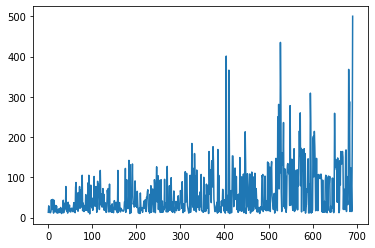

In [ ]:
plt.plot(scores_all[0])

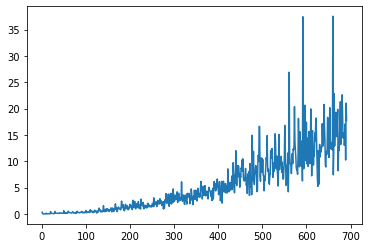

In [ ]:
plt.plot(losses_all)

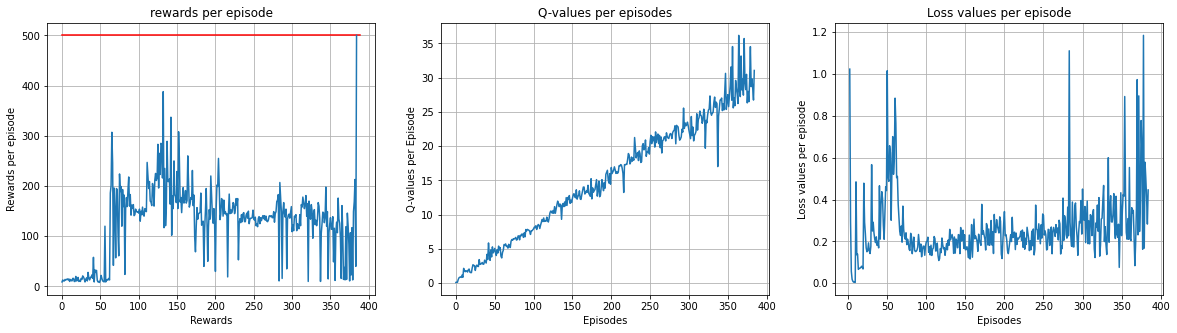

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.title('rewards per episode')
plt.xlabel("Rewards")
plt.ylabel('Rewards per episode')
plt.plot(np.ones(390)*500, color= 'red')
plt.plot(scores_all[0])
plt.grid()

plt.subplot(132)
plt.title('Q-values per episodes')
plt.xlabel('Episodes')
plt.ylabel('Q-values per Episode')
plt.plot(q_values_all)
plt.grid()

plt.subplot(133)
plt.title('Loss values per episode')
plt.xlabel("Episodes")
plt.ylabel('Loss values per episode')
plt.plot(losses_all)
plt.grid()
# plt.yscale('log')
plt.show()

In [ ]:
# Load a model
model = Dueling_DQNAgent(env).q_net
model.load_state_dict(torch.load('model.ckpt'))
model.eval()

Model(
  (feature): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
  )
  (advantage): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (value): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
!pip install gym > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

In [ ]:
import tqdm
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
import numpy as np
import pandas as pd
import seaborn as sns
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path
import random, os.path, math, glob, csv, base64, itertools, sys
from pprint import pprint
import io
from IPython.display import HTML
import gym
import torch
import torch.nn as nn
import numpy as np
from collections import deque
from itertools import count
import torch.nn.functional as F
from torch.nn.utils.clip_grad import clip_grad_norm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# The following code is will be used to visualize the environments.

def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
  
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
def render(model):

  # This block displays your policy in a video
  video_env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)

  done = False
  reward_episode = 0
  state = video_env.reset()
  k = 0 # End of the episode
  while not done:
      action, _ = model.selection_action(state, epsilon= 0.01)
      # action= torch.argmax(action, dim=1)[0].item()
      next_state, reward, done, info = video_env.step(action)
      reward_episode += reward
      state = next_state
      k += 1
      if k > 500:
        break

  video_env.close()
  show_video("./gym-results")

  print(f'Reward: {reward_episode}')


render(q_net)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Reward: 401.0
